In [545]:
import time

def exec_time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} 실행 시간: {end_time - start_time:.5f}초")
        return result
    return wrapper

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Literal
import math
from filterpy.monte_carlo import multinomial_resample
from filterpy.monte_carlo import residual_resample
from filterpy.monte_carlo import stratified_resample
from filterpy.monte_carlo import systematic_resample
from dtaidistance import dtw


UnitType = Literal['meter', 'coordinate']

class ParticleFilter:
    def __init__(self, m_map, gaussian_params, num_particles: int, map_constraints: np.ndarray, step_noise=0.2, gyro_noise=0.1, map_noise=0.2, plot=False, unit: UnitType = 'coordinate'):
        """
        Initialize the particle filter.
        :param gaussian_params: Dict with Gaussian parameters {'mean_x', 'mean_y', 'std_x', 'std_y'}
        :param num_particles: Number of particles.
        :param map_constraints: Spatial constraints of the map (e.g., walls, paths).
        :param gyro_noise: Standard deviation of noise added to direction changes.
        :param map_noise: Standard deviation of noise in map matching.
        """
        m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])
        self.m_map = {(row.X, row.Y): row.mag for row in m_map_df.itertuples()}
        self.gaussian_params = gaussian_params  
        self.num_particles = num_particles
        self.map_constraints = map_constraints
        self.gyro_noise = gyro_noise
        self.step_noise = step_noise
        self.map_noise = map_noise
        self.plot = plot
        self.unit = unit
        
        self.particles = self.initialize_particles()


    @exec_time_decorator
    def initialize_particles(self):
        """
        Randomly initialize particles based on map constraints.
        """
        particles = pd.DataFrame(columns=['x', 'y', 'direction', 'weight'])

        for _ in range(self.num_particles):
            while True:
                # Generate x and y from Gaussian distribution
                x = np.random.normal(self.gaussian_params['mean_x'], self.gaussian_params['std_x'])
                y = np.random.normal(self.gaussian_params['mean_y'], self.gaussian_params['std_y'])
                
                # Check if the generated coordinates are within the map constraints
                if self.map_constraints_check(x, y):
                    # print(f"({x},{y} is in map")
                    break

            # Random direction for the particle
            direction = np.arctan2(x - self.gaussian_params['mean_x'], y - self.gaussian_params['mean_y'])  # Direction in radians
            new_particle = pd.DataFrame([{'x': x, 'y': y, 'direction': direction, 'weight': 1.0}])

            # Initialize the particle with weight 1.0
            particles = pd.concat([particles, new_particle], ignore_index=True)

        return particles


    @exec_time_decorator
    def move_particles(self, step_length: float, step_radian: float):
        """
        Move particles based on step length and gyro data.
        """
        if self.unit == 'coordinate':
            step_length /= 0.6

        # Update direction with gyro data and noise
        delta_direction = step_radian + np.random.normal(0, self.gyro_noise)
        self.particles.loc[:, 'direction'] += delta_direction

        # Move particles in updated direction
        dx = (step_length + self.step_noise * step_length) * np.cos(self.particles.loc[:, 'direction'])
        dy = (step_length + self.step_noise * step_length) * np.sin(self.particles.loc[:, 'direction'])
        self.particles.loc[:, 'x'] += dx
        self.particles.loc[:, 'y'] += dy


    # @exec_time_decorator
    @staticmethod
    def calculate_weights_worker(self, particle, observed_vector: pd.DataFrame, step_length):
        """
        Calculate particle weights using DTW similarity.
        """

        if self.map_constraints_check(particle['x'], particle['y']) is False:
            # particle['weight'] = 0.000001
            particle['weight'] *= 0.01
        else:
            # Simulate predicted vector (from M-Map) at particle's position
            predicted_vector = self.get_m_map_vector_(particle, step_length)  # Replace with map-based vector lookup
            
            observed_vector = observed_vector['mag'].to_numpy()

            # observed_vector_mag_mean = sum(observed_vector) / len(observed_vector)  
            # observed_vector_result = [[idx, item - observed_vector_mag_mean] for idx, item in enumerate(observed_vector)]

            # predicted_vector_mag_mean = sum(predicted_vector) / len(predicted_vector)  
            # predicted_vector_result = [[idx, item - predicted_vector_mag_mean] for idx, item in enumerate(predicted_vector)]

            # observed_vector_mag_mean = sum(observed_vector) / len(observed_vector)  
            observed_vector_result = np.array([item for idx, item in enumerate(observed_vector)])

            # predicted_vector_mag_mean = sum(predicted_vector) / len(predicted_vector)  
            predicted_vector_result = np.array([item for idx, item in enumerate(predicted_vector)])

            # distance, _ = fastdtw(observed_vector_result, predicted_vector_result, dist=euclidean)
            distance = dtw.distance_fast(observed_vector_result, predicted_vector_result)

            distance = round(distance*0.001, 4)
            particle['weight'] *= np.exp(- distance**2 / (2 * self.map_noise**2))

            # print(f"particle: ({particle['x']}, {particle['y']}), distance:{distance}, weight: {particle['weight']}")
        
        return particle
    
    
    @exec_time_decorator
    def calculate_weights(self, observed_vector: pd.DataFrame, step_length):
        """
        Calculate particle weights
        """
        
        # 병렬 실행 X
        # self.particles = [ self.calculate_weights_worker(
        #             particle,
        #             observed_vector,
        #             self.m_map,
        #             self.map_constraints,
        #             self.step_length,
        #             self.map_noise
        # ) for particle in self.particles]
        
        # 병렬 실행 O
        futures = [] 
        with ThreadPoolExecutor() as executor:
            for _, particle in self.particles.iterrows():
                # 작업을 개별적으로 제출
                future = executor.submit(self.calculate_weights_worker,
                    self,
                    particle,
                    observed_vector,
                    step_length
                )
                futures.append(future)

            # 완료된 작업에서 결과 수집
            self.particles = pd.DataFrame([future.result() for future in as_completed(futures)])
        
        self.particles.loc[:, 'weight'] += 1.e-300      # avoid round-off to zero
        self.particles.loc[:, 'weight'] /= sum(self.particles.loc[:, 'weight']) # normalize -> Posterior


    @exec_time_decorator
    def resample_particles(self):   
        """
        Resample particles based on their weights.
        """
        def resample_from_index(particles, indexes):
            # Resample particles using the given indexes
            particles[:] = particles.iloc[indexes].reset_index(drop=True)
    
            # Update weights to be uniform
            particles['weights'] = 1.0 / len(particles)
        def neff(weights):
            return 1. / np.sum(np.square(weights))

        N = len(self.particles)

        # resample if too few effective particles
        # if neff(self.particles.loc[:, 'weight']) < N/2:
        indexes = multinomial_resample(self.particles.loc[:, 'weight'])
        resample_from_index(self.particles, indexes)
        # assert np.allclose(self.particles.loc[:, 'weight'], 1/N)


    @exec_time_decorator
    def estimate_position(self, use_weighted_average=False):
        """
        Estimate user position based on particle distribution using a hybrid strategy.
        
        Args:
            use_weighted_average (bool): Flag to switch to weighted average strategy.
            
        Returns:
            tuple: (x_mean, y_mean) representing the estimated position.
        """
        if not use_weighted_average:
            # 초기 단계: 최대 가중치를 가진 입자의 위치 사용
            max_weight_particle = self.particles.loc[self.particles['weight'].idxmax()]
            return max_weight_particle['x'], max_weight_particle['y']
        else:
            # 수렴 이후: 상위 50% 가중치 입자들의 가중 평균 사용
            half_count = len(self.particles) // 2
            top_particles = self.particles.nlargest(half_count, 'weight')  # 상위 50% 선택
            total_weight = top_particles['weight'].sum()
            
            x_mean = (top_particles['x'] * top_particles['weight']).sum() / total_weight
            y_mean = (top_particles['y'] * top_particles['weight']).sum() / total_weight
            
            return x_mean, y_mean


    @exec_time_decorator
    def run_filter(self, observed_vector: pd.DataFrame, step_length, step_radian, use_weighted_average: bool):
        """ 
        Run the particle filter over a sequence of observations.
        """
        positions = []

        if self.plot:
            particles = pd.DataFrame(self.particles)
            # plt.scatter(particles[:]['x'], particles[:]['y'], alpha=0.2, color='g')

        print(f"# of particle: {len(self.particles)}")
        self.move_particles(step_length, step_radian)

        self.calculate_weights(observed_vector, step_length)
        self.resample_particles()
        positions.append(self.estimate_position(use_weighted_average))
        if self.plot:
            sampled_particle = particles.sample(frac=0.1, random_state=42)  # 10% 샘플링
            # for _, particle in sampled_particle.iterrows():
            #     # 방향 벡터 (cos, sin)로 계산
            #     dx = np.cos(particle['direction'])
            #     dy = np.sin(particle['direction'])
                
            #     # weight에 따라 화살표 길이를 조정 (0.1에서 1까지의 범위)
            #     scale_factor = particle['weight']  # weight 값에 비례하여 화살표 길이 조정
    
            #     # 길이를 weight에 맞게 스케일링
            #     dx *= scale_factor
            #     dy *= scale_factor

            #     # 화살표 그리기 (x, y에서 방향 (dx, dy)로 이동)
            #     plt.arrow(particle['x'], particle['y'], dx, dy, head_width=0.1, head_length=0.1, alpha=scale_factor, fc='blue', ec='blue')
            plt.scatter(sampled_particle[:]['x'], sampled_particle[:]['y'], color='red', s=20, alpha=sampled_particle[:]['weight'])

        return positions


    # @exec_time_decorator
    def map_constraints_check(self, x: float, y: float) -> bool:
        """
        if the (x,y) impossible return false  
        """
        x_max = self.map_constraints.shape[0] - 0.5
        y_max = self.map_constraints.shape[1] - 0.5

        if (0 <= x < x_max) and (0 <= y < y_max):
            return not self.map_constraints[math.floor(x), math.floor(y)]
        else:
            return False


    # @exec_time_decorator
    def get_m_map_vector_(self, particle, step_length):
        """
        find the points from (x1, y1) to (x2, y2) 
        concat the magnitudes of points
        """
        vector = []

        dx = step_length * np.cos(particle['direction'])
        dy = step_length * np.sin(particle['direction'])

        x1 = particle['x'] - dx
        y1 = particle['y'] - dy
        
        x2 = particle['x']
        y2 = particle['y']

        
        # m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])

        # (x1, y1)에서 (x2, y2)까지 이동하는 단계 수 계산
        # TODO: 걸음 상수 바꾸기
        # num_steps = math.dist((x1,y1),(x2,y2)) / 0.65
        num_steps = 10

        # m_map의 magnitude 값을 읽어서 벡터화
        for i in range(num_steps + 1):
            # 시작점과 끝점 사이를 보간하여 (x, y) 계산
            x = np.round(x1 + (x2 - x1) * i / num_steps, 1)
            y = np.round(y1 + (y2 - y1) * i / num_steps, 1)
            
            x = float(x) if isinstance(x, np.ndarray) else x
            y = float(y) if isinstance(y, np.ndarray) else y

            magnitude = self.m_map.get((x,y), 999.9)

            vector.append(magnitude)

        return vector



M-Map Origianl Data Shape: (154, 66)


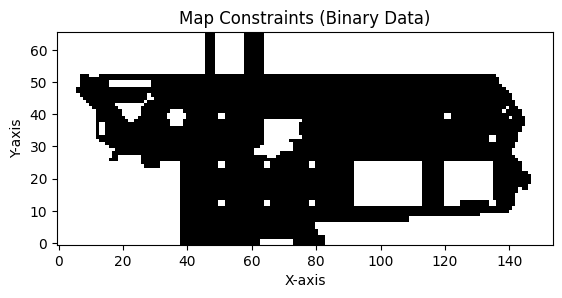

M-Map Origianl Data Shape: (1016400, 3)


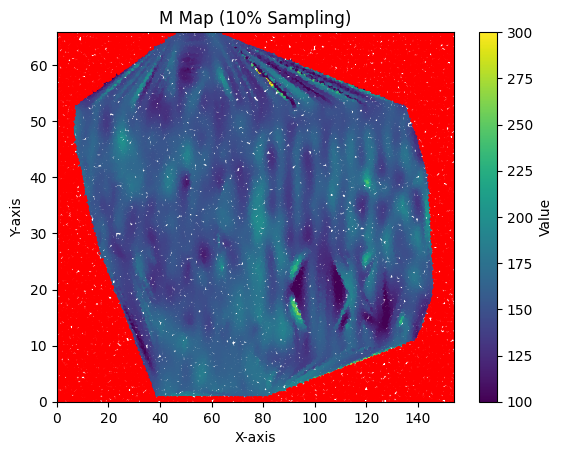

/var/folders/ny/mjm70zt108z4k8f32b0pwzsr0000gn/T/ipykernel_2798/4261976214.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  particles = pd.concat([particles, new_particle], ignore_index=True)


initialize_particles 실행 시간: 0.25409초


In [547]:
import math

map_constraints = np.loadtxt('../data/obstacle_mask.txt', dtype=bool)
m_map = pd.read_csv("../data/M_map_version2.csv")

# Constraint Ploting
print(f"M-Map Origianl Data Shape: {map_constraints.shape}")
plt.imshow(map_constraints.T, cmap='gray', origin='lower')
plt.title("Map Constraints (Binary Data)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.margins(0,0)
plt.show()

# M-MAP Ploting
print(f"M-Map Origianl Data Shape: {m_map.shape}")
sampled_map = m_map.sample(frac=0.1, random_state=42)  # 10% 샘플링
obstacle_sampled_map = sampled_map[sampled_map['mag'] == 999.9]
sampled_map = sampled_map[sampled_map['mag'] != 999.9]

scatter = plt.scatter(sampled_map['X'], sampled_map['Y'], c=sampled_map['mag'], s=1, vmin=100, vmax=300)
plt.scatter(obstacle_sampled_map['X'], obstacle_sampled_map['Y'], color='red', s=1)
plt.colorbar(scatter, label="Value")
plt.title("M Map (10% Sampling)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.margins(0,0)
plt.show()

# initial state
# gaussian_params1 = {"mean_x": 92, "mean_y": 47, "std_x": 0.1, "std_y": 0.1}
# gaussian_params2 = {"mean_x": 114, "mean_y": 25, "std_x": 0.1, "std_y": 0.1}
# gaussian_params3 = {"mean_x": 33, "mean_y": 28, "std_x": 0.1, "std_y": 0.1}
gaussian_params4 = {"mean_x": 49, "mean_y": 52, "std_x": 0.1, "std_y": 0.1}

# Initialize particle filter
pf = ParticleFilter(
    num_particles=3000,
    gaussian_params=gaussian_params4,
    m_map=m_map,
    map_constraints=map_constraints,
    gyro_noise=math.radians(0.1),
    step_noise=0.02,
    plot = True,
    unit='coordinate'
)

assert that len(step_length): 60 = len(step_orientation_radians): 60
# of particle: 3000
move_particles 실행 시간: 0.00113초
calculate_weights 실행 시간: 0.30329초
resample_particles 실행 시간: 0.00106초
estimate_position 실행 시간: 0.00009초
run_filter 실행 시간: 0.39629초
[(47.925541585773715, 52.666000858486925)]


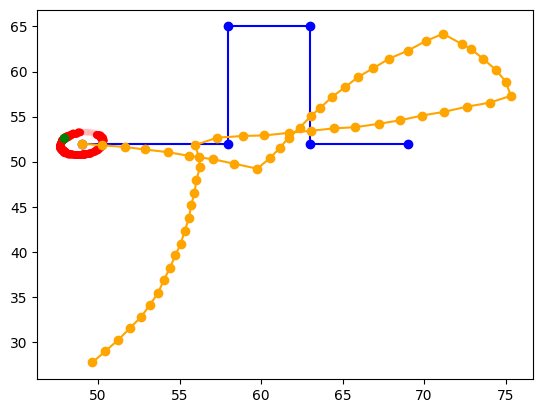

# of particle: 3000
move_particles 실행 시간: 0.00267초
calculate_weights 실행 시간: 0.35667초
resample_particles 실행 시간: 0.00129초
estimate_position 실행 시간: 0.00007초
run_filter 실행 시간: 0.36528초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172)]


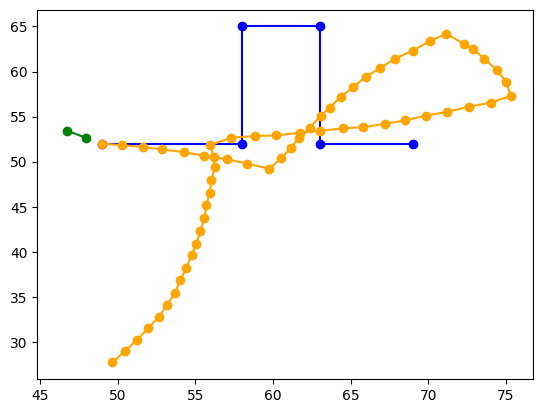

# of particle: 3000
move_particles 실행 시간: 0.00240초
calculate_weights 실행 시간: 0.42563초
resample_particles 실행 시간: 0.00095초
estimate_position 실행 시간: 0.00006초
run_filter 실행 시간: 0.43418초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936)]


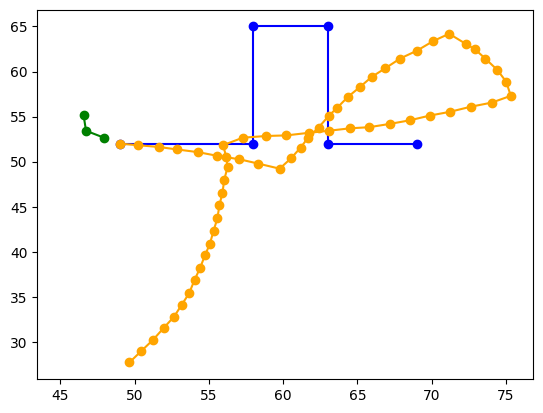

# of particle: 3000
move_particles 실행 시간: 0.00115초
calculate_weights 실행 시간: 0.29883초
resample_particles 실행 시간: 0.00098초
estimate_position 실행 시간: 0.00006초
run_filter 실행 시간: 0.31551초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992)]


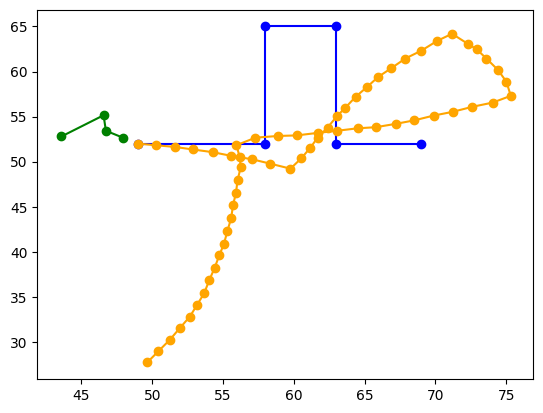

# of particle: 3000
move_particles 실행 시간: 0.00122초
calculate_weights 실행 시간: 0.32621초
resample_particles 실행 시간: 0.00096초
estimate_position 실행 시간: 0.00007초
run_filter 실행 시간: 0.33292초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735)]


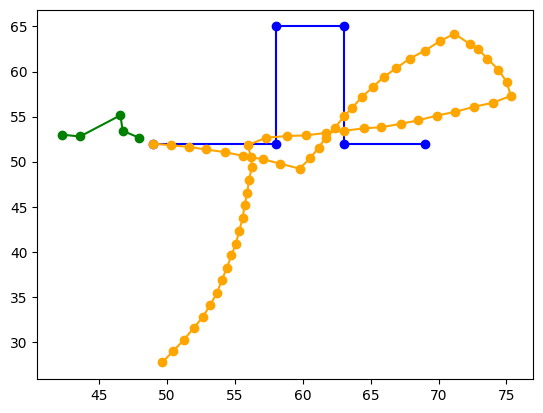

# of particle: 3000
move_particles 실행 시간: 0.00155초
calculate_weights 실행 시간: 0.37587초
resample_particles 실행 시간: 0.00098초
estimate_position 실행 시간: 0.00072초
run_filter 실행 시간: 0.38440초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742)]


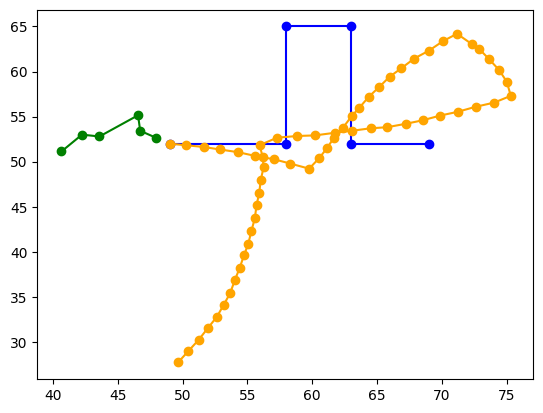

# of particle: 3000
move_particles 실행 시간: 0.00262초
calculate_weights 실행 시간: 0.31158초
resample_particles 실행 시간: 0.00097초
estimate_position 실행 시간: 0.00072초
run_filter 실행 시간: 0.32096초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704)]


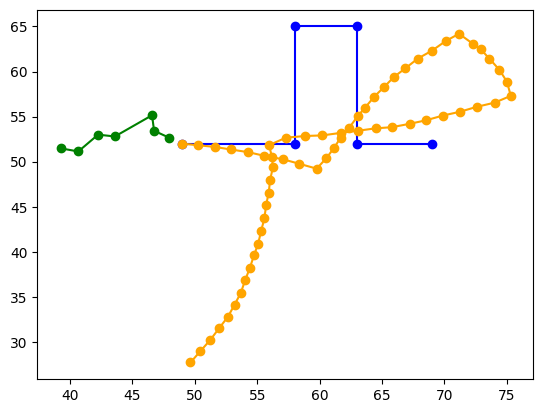

# of particle: 3000
move_particles 실행 시간: 0.00277초
calculate_weights 실행 시간: 0.62089초
resample_particles 실행 시간: 0.00094초
estimate_position 실행 시간: 0.00069초
run_filter 실행 시간: 0.62968초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144)]


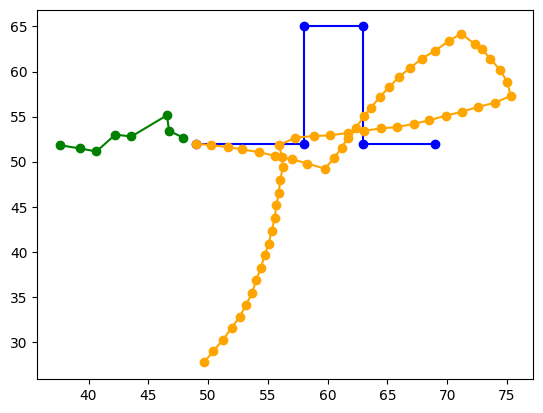

# of particle: 3000
move_particles 실행 시간: 0.00131초
calculate_weights 실행 시간: 0.41467초
resample_particles 실행 시간: 0.00092초
estimate_position 실행 시간: 0.00068초
run_filter 실행 시간: 0.42174초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853)]


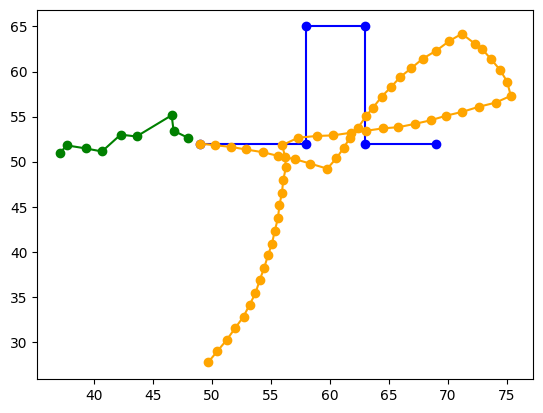

# of particle: 3000
move_particles 실행 시간: 0.00217초
calculate_weights 실행 시간: 0.34922초
resample_particles 실행 시간: 0.00110초
estimate_position 실행 시간: 0.00073초
run_filter 실행 시간: 0.35808초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205)]


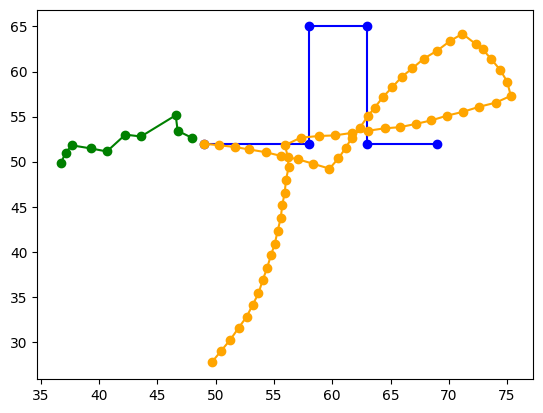

# of particle: 3000
move_particles 실행 시간: 0.00144초
calculate_weights 실행 시간: 0.35499초
resample_particles 실행 시간: 0.00103초
estimate_position 실행 시간: 0.00072초
run_filter 실행 시간: 0.36368초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073)]


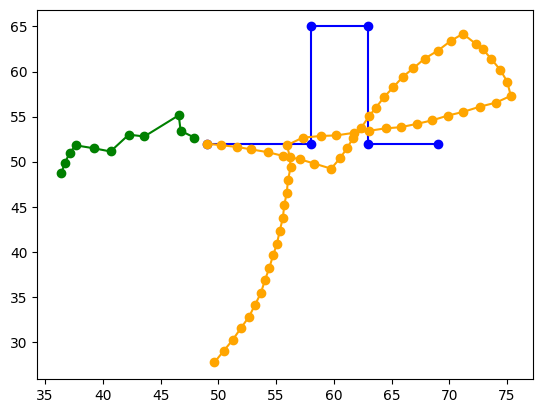

# of particle: 3000
move_particles 실행 시간: 0.00300초
calculate_weights 실행 시간: 0.42672초
resample_particles 실행 시간: 0.00095초
estimate_position 실행 시간: 0.00068초
run_filter 실행 시간: 0.43533초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858)]


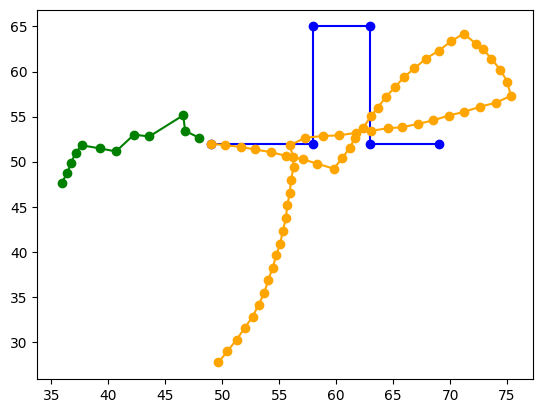

# of particle: 3000
move_particles 실행 시간: 0.00192초
calculate_weights 실행 시간: 0.66296초
resample_particles 실행 시간: 0.00117초
estimate_position 실행 시간: 0.00081초
run_filter 실행 시간: 0.67184초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477)]


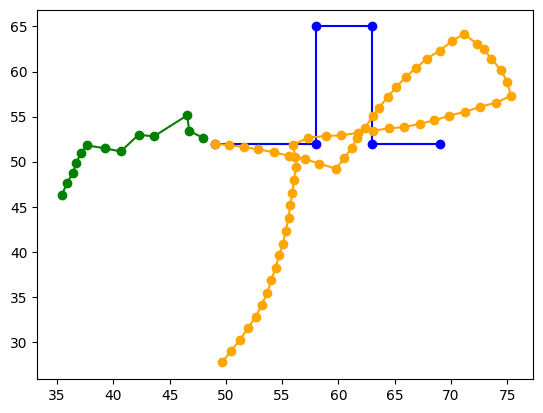

# of particle: 3000
move_particles 실행 시간: 0.00135초
calculate_weights 실행 시간: 0.34889초
resample_particles 실행 시간: 0.00108초
estimate_position 실행 시간: 0.00071초
run_filter 실행 시간: 0.35629초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156)]


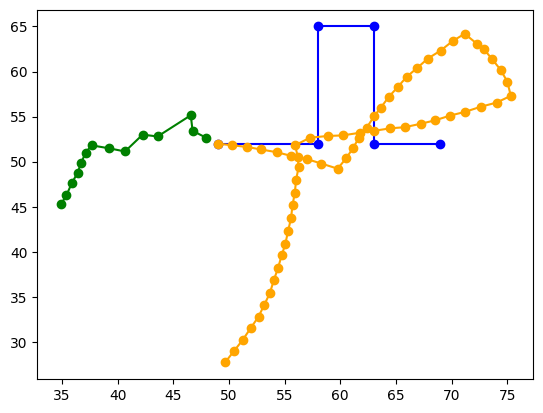

# of particle: 3000
move_particles 실행 시간: 0.00895초
calculate_weights 실행 시간: 0.40120초
resample_particles 실행 시간: 0.00093초
estimate_position 실행 시간: 0.00070초
run_filter 실행 시간: 0.41611초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535)]


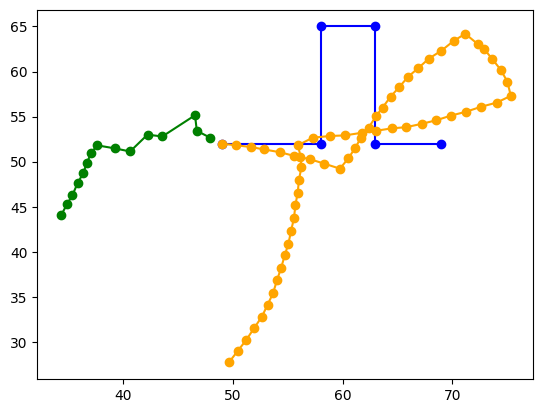

# of particle: 3000
move_particles 실행 시간: 0.00241초
calculate_weights 실행 시간: 0.34551초
resample_particles 실행 시간: 0.00098초
estimate_position 실행 시간: 0.00067초
run_filter 실행 시간: 0.35414초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635)]


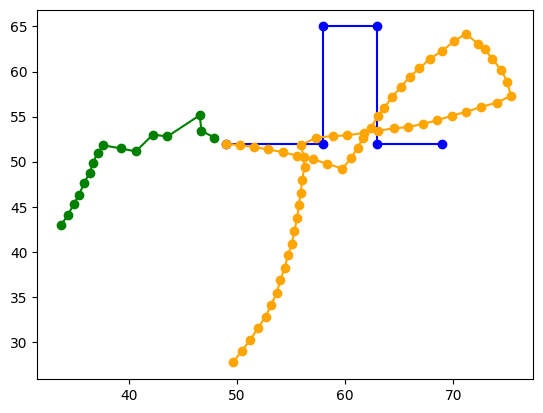

# of particle: 3000
move_particles 실행 시간: 0.00184초
calculate_weights 실행 시간: 0.39726초
resample_particles 실행 시간: 0.00107초
estimate_position 실행 시간: 0.00071초
run_filter 실행 시간: 0.40519초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225)]


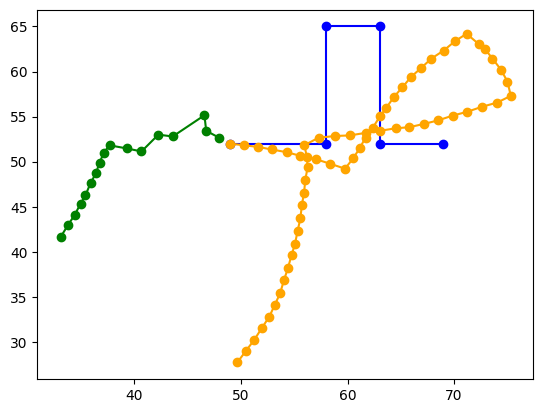

# of particle: 3000
move_particles 실행 시간: 0.00206초
calculate_weights 실행 시간: 0.38383초
resample_particles 실행 시간: 0.00094초
estimate_position 실행 시간: 0.00086초
run_filter 실행 시간: 0.39265초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526)]


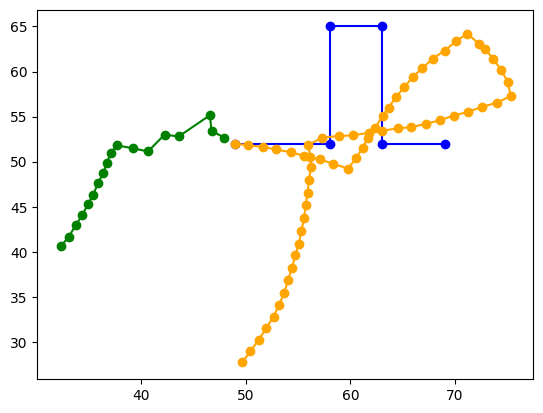

# of particle: 3000
move_particles 실행 시간: 0.00170초
calculate_weights 실행 시간: 0.64355초
resample_particles 실행 시간: 0.00095초
estimate_position 실행 시간: 0.00065초
run_filter 실행 시간: 0.65079초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798)]


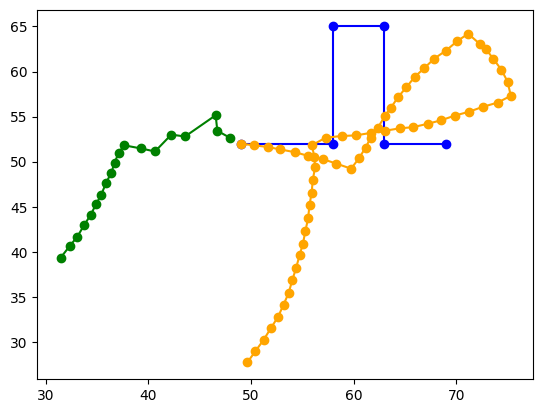

# of particle: 3000
move_particles 실행 시간: 0.00111초
calculate_weights 실행 시간: 0.39951초
resample_particles 실행 시간: 0.00109초
estimate_position 실행 시간: 0.00076초
run_filter 실행 시간: 0.40669초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565)]


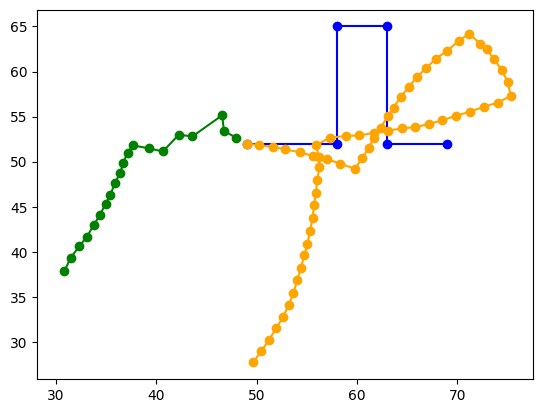

# of particle: 3000
move_particles 실행 시간: 0.00149초
calculate_weights 실행 시간: 0.33231초
resample_particles 실행 시간: 0.00093초
estimate_position 실행 시간: 0.00065초
run_filter 실행 시간: 0.33930초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

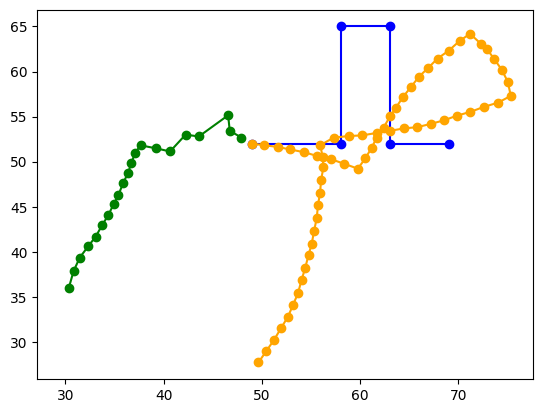

# of particle: 3000
move_particles 실행 시간: 0.00173초
calculate_weights 실행 시간: 0.32835초
resample_particles 실행 시간: 0.00093초
estimate_position 실행 시간: 0.00067초
run_filter 실행 시간: 0.33623초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

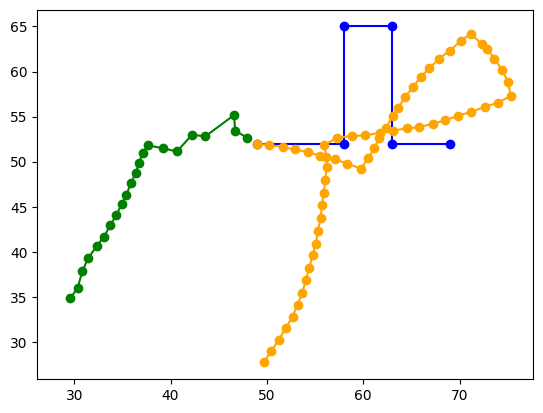

# of particle: 3000
move_particles 실행 시간: 0.00136초
calculate_weights 실행 시간: 0.42256초
resample_particles 실행 시간: 0.00110초
estimate_position 실행 시간: 0.00067초
run_filter 실행 시간: 0.42990초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

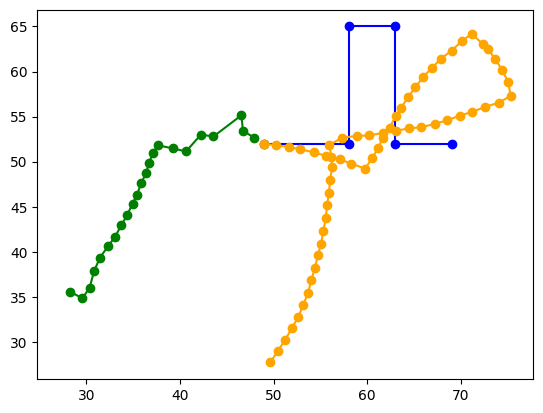

# of particle: 3000
move_particles 실행 시간: 0.00144초
calculate_weights 실행 시간: 0.62118초
resample_particles 실행 시간: 0.00096초
estimate_position 실행 시간: 0.00067초
run_filter 실행 시간: 0.62819초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

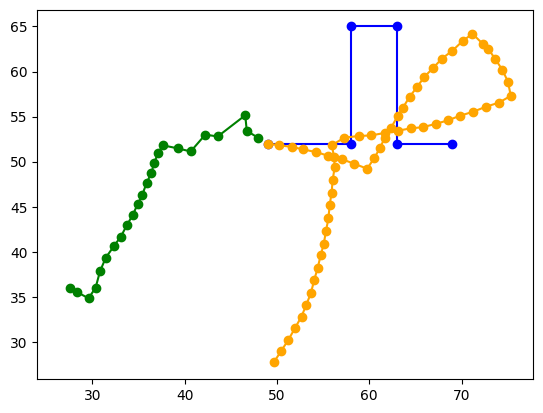

# of particle: 3000
move_particles 실행 시간: 0.00147초
calculate_weights 실행 시간: 0.34135초
resample_particles 실행 시간: 0.00105초
estimate_position 실행 시간: 0.00075초
run_filter 실행 시간: 0.34856초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

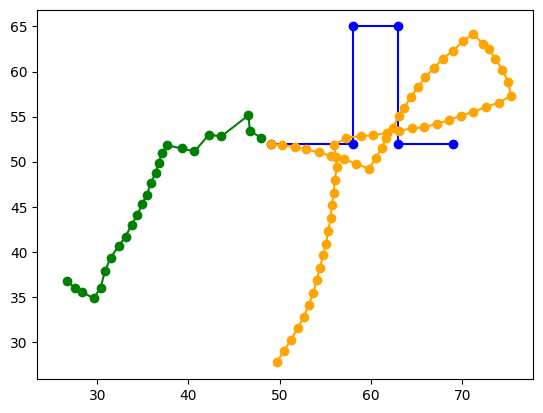

# of particle: 3000
move_particles 실행 시간: 0.00152초
calculate_weights 실행 시간: 0.33642초
resample_particles 실행 시간: 0.00104초
estimate_position 실행 시간: 0.00069초
run_filter 실행 시간: 0.34370초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

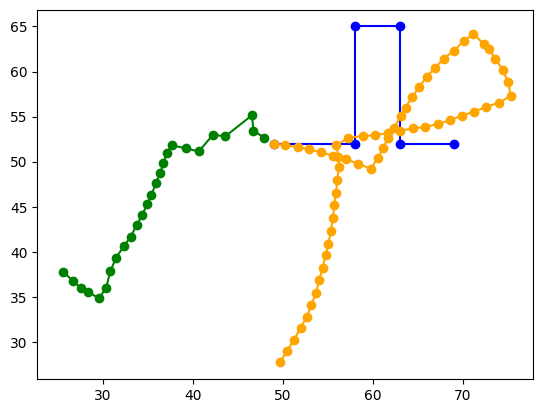

# of particle: 3000
move_particles 실행 시간: 0.00167초
calculate_weights 실행 시간: 0.18758초
resample_particles 실행 시간: 0.00099초
estimate_position 실행 시간: 0.00073초
run_filter 실행 시간: 0.19536초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

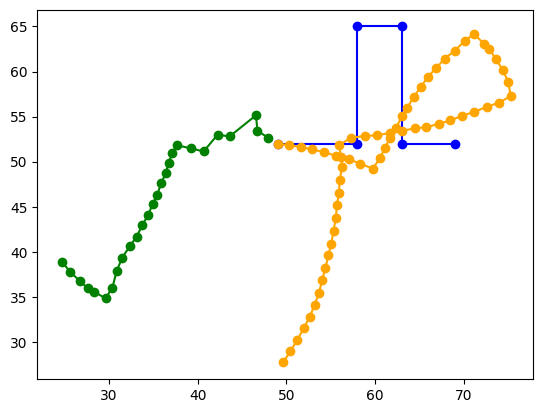

# of particle: 3000
move_particles 실행 시간: 0.00192초
calculate_weights 실행 시간: 0.14471초
resample_particles 실행 시간: 0.00081초
estimate_position 실행 시간: 0.00066초
run_filter 실행 시간: 0.15243초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

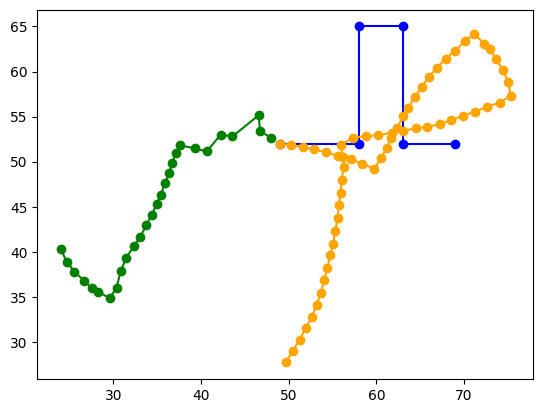

# of particle: 3000
move_particles 실행 시간: 0.00095초
calculate_weights 실행 시간: 0.38426초
resample_particles 실행 시간: 0.00101초
estimate_position 실행 시간: 0.00068초
run_filter 실행 시간: 0.39086초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

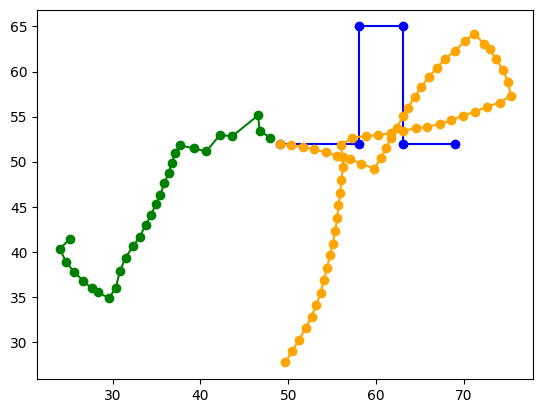

# of particle: 3000
move_particles 실행 시간: 0.00165초
calculate_weights 실행 시간: 0.33227초
resample_particles 실행 시간: 0.00093초
estimate_position 실행 시간: 0.00066초
run_filter 실행 시간: 0.33952초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

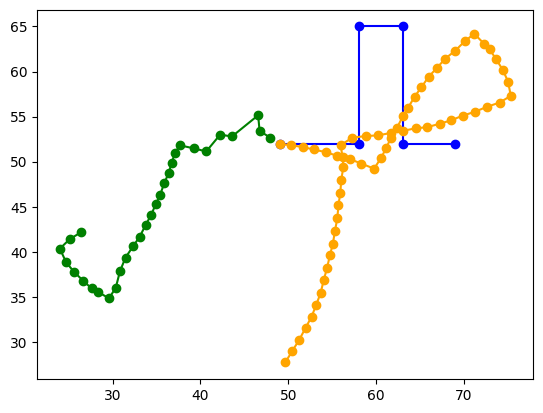

# of particle: 3000
move_particles 실행 시간: 0.00349초
calculate_weights 실행 시간: 0.39204초
resample_particles 실행 시간: 0.00107초
estimate_position 실행 시간: 0.00161초
run_filter 실행 시간: 0.40369초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

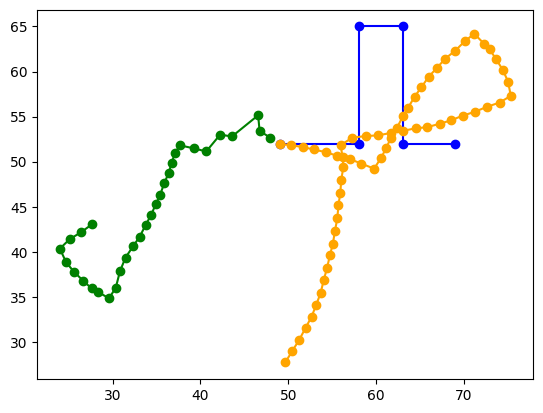

# of particle: 3000
move_particles 실행 시간: 0.00162초
calculate_weights 실행 시간: 0.32871초
resample_particles 실행 시간: 0.00092초
estimate_position 실행 시간: 0.00058초
run_filter 실행 시간: 0.33646초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

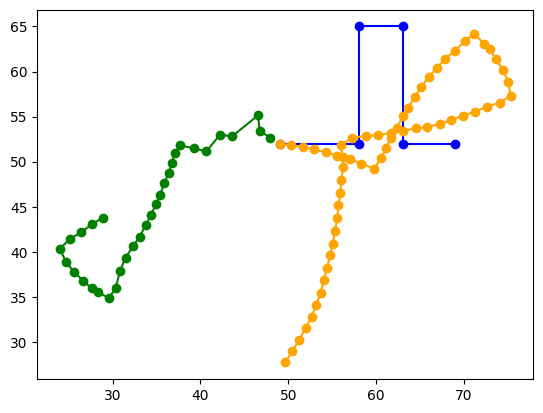

# of particle: 3000
move_particles 실행 시간: 0.00088초
calculate_weights 실행 시간: 0.35755초
resample_particles 실행 시간: 0.00181초
estimate_position 실행 시간: 0.00146초
run_filter 실행 시간: 0.38171초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

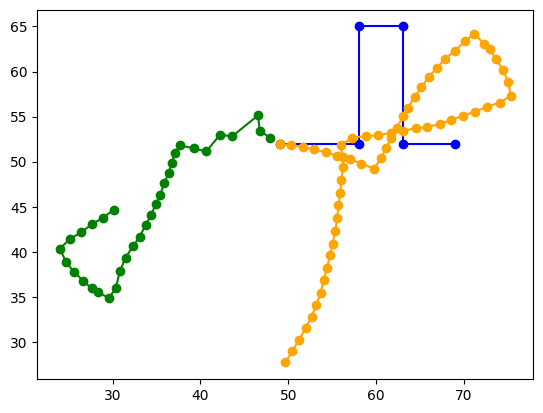

# of particle: 3000
move_particles 실행 시간: 0.00178초
calculate_weights 실행 시간: 0.60842초
resample_particles 실행 시간: 0.00095초
estimate_position 실행 시간: 0.00057초
run_filter 실행 시간: 0.61591초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

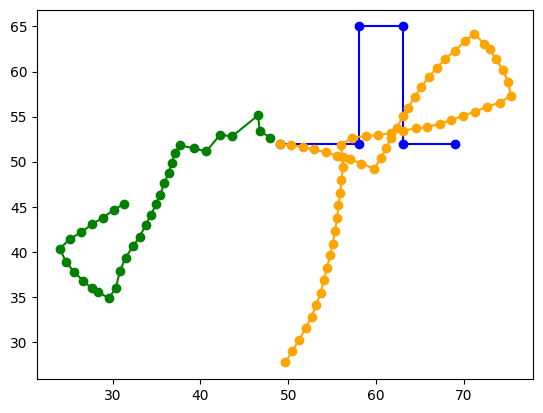

# of particle: 3000
move_particles 실행 시간: 0.00168초
calculate_weights 실행 시간: 0.32858초
resample_particles 실행 시간: 0.00095초
estimate_position 실행 시간: 0.00068초
run_filter 실행 시간: 0.33673초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

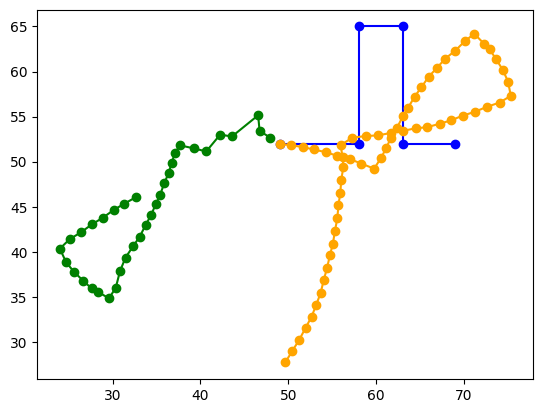

# of particle: 3000
move_particles 실행 시간: 0.00168초
calculate_weights 실행 시간: 0.41805초
resample_particles 실행 시간: 0.00131초
estimate_position 실행 시간: 0.00072초
run_filter 실행 시간: 0.42994초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

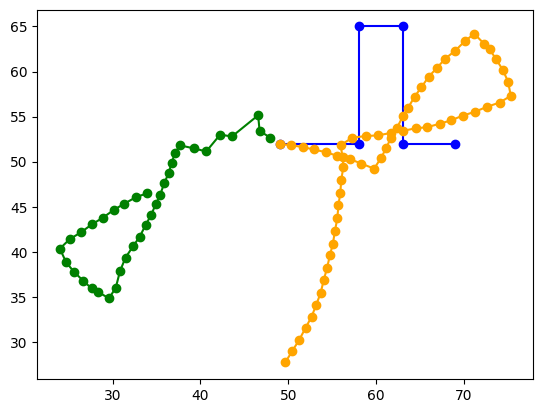

# of particle: 3000
move_particles 실행 시간: 0.00112초
calculate_weights 실행 시간: 0.33795초
resample_particles 실행 시간: 0.00113초
estimate_position 실행 시간: 0.00059초
run_filter 실행 시간: 0.34483초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

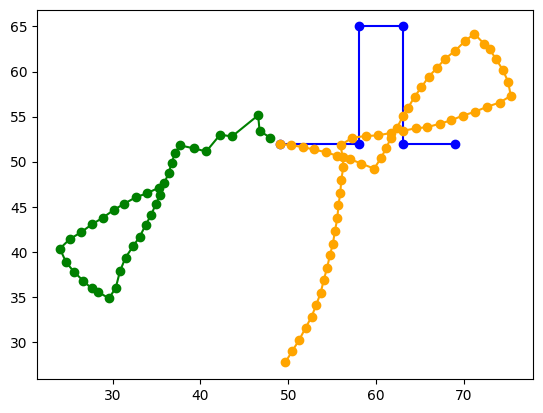

# of particle: 3000
move_particles 실행 시간: 0.00251초
calculate_weights 실행 시간: 0.33909초
resample_particles 실행 시간: 0.01126초
estimate_position 실행 시간: 0.00680초
run_filter 실행 시간: 0.68487초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

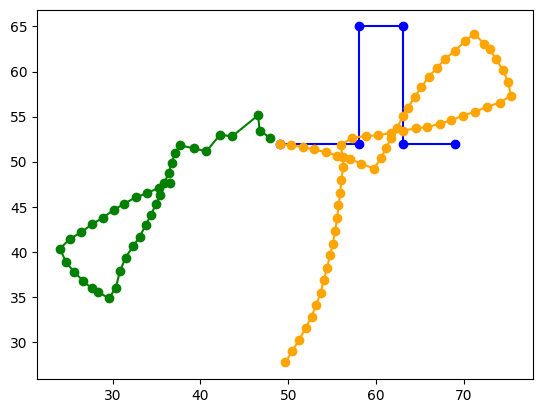

# of particle: 3000
move_particles 실행 시간: 0.00151초
calculate_weights 실행 시간: 0.33050초
resample_particles 실행 시간: 0.00099초
estimate_position 실행 시간: 0.00063초
run_filter 실행 시간: 0.34822초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

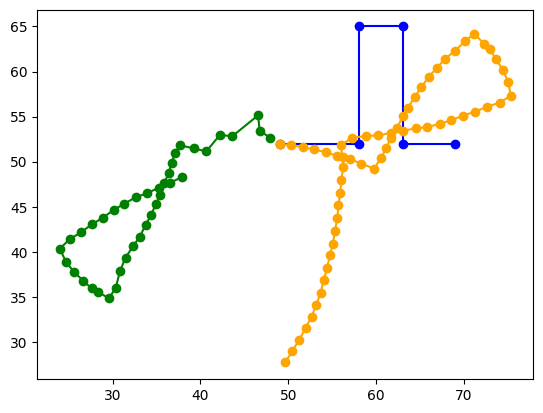

# of particle: 3000
move_particles 실행 시간: 0.00177초
calculate_weights 실행 시간: 0.33976초
resample_particles 실행 시간: 0.00092초
estimate_position 실행 시간: 0.00057초
run_filter 실행 시간: 0.34694초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

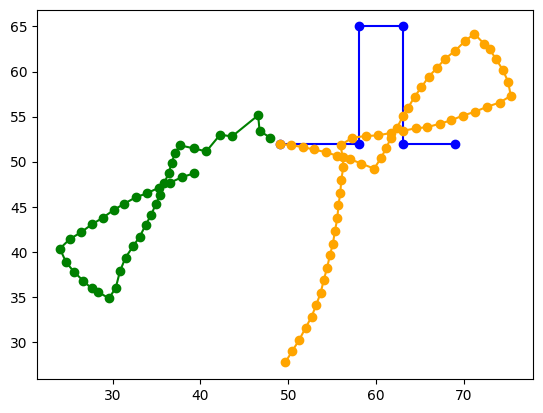

# of particle: 3000
move_particles 실행 시간: 0.00152초
calculate_weights 실행 시간: 0.39139초
resample_particles 실행 시간: 0.00099초
estimate_position 실행 시간: 0.00059초
run_filter 실행 시간: 0.39840초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

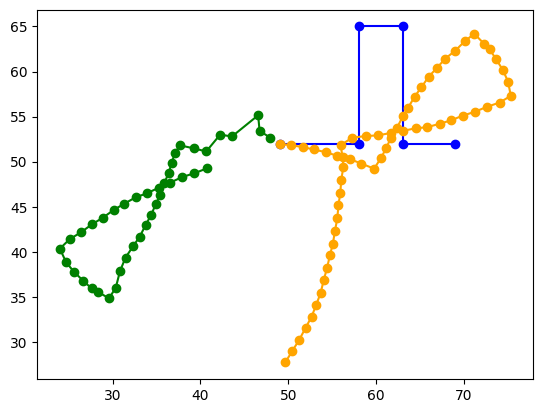

# of particle: 3000
move_particles 실행 시간: 0.00138초
calculate_weights 실행 시간: 0.33904초
resample_particles 실행 시간: 0.00114초
estimate_position 실행 시간: 0.00116초
run_filter 실행 시간: 0.34676초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

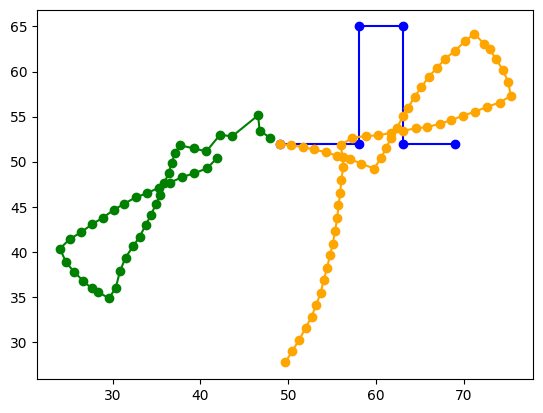

# of particle: 3000
move_particles 실행 시간: 0.00174초
calculate_weights 실행 시간: 0.69870초
resample_particles 실행 시간: 0.00094초
estimate_position 실행 시간: 0.00058초
run_filter 실행 시간: 0.70604초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

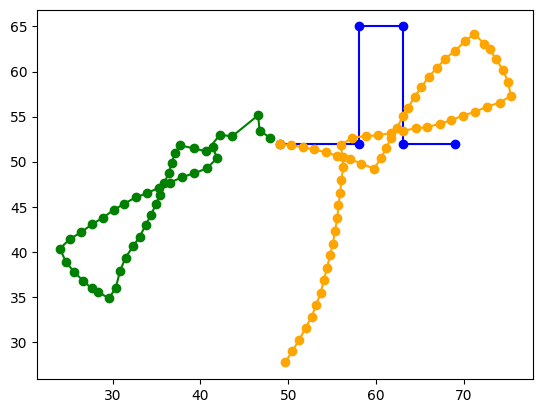

# of particle: 3000
move_particles 실행 시간: 0.00195초
calculate_weights 실행 시간: 0.33442초
resample_particles 실행 시간: 0.00095초
estimate_position 실행 시간: 0.00059초
run_filter 실행 시간: 0.34182초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

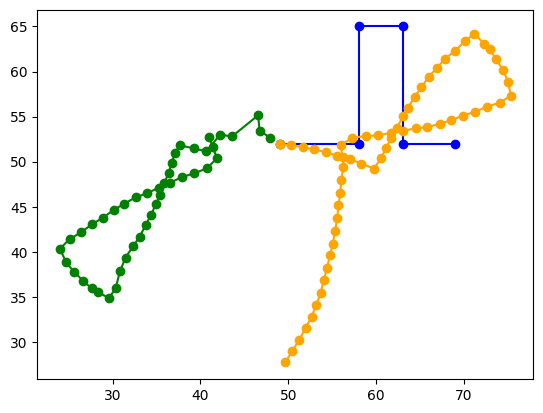

# of particle: 3000
move_particles 실행 시간: 0.00223초
calculate_weights 실행 시간: 0.08750초
resample_particles 실행 시간: 0.00082초
estimate_position 실행 시간: 0.00059초
run_filter 실행 시간: 0.09532초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

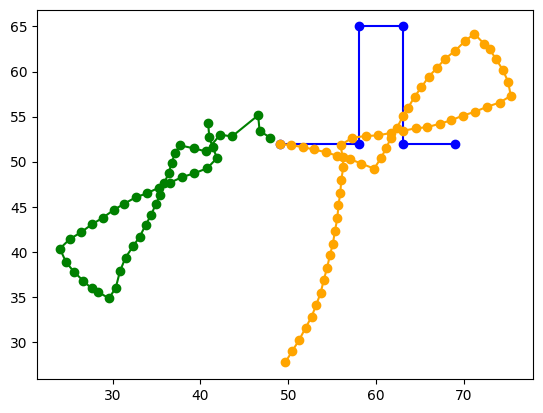

# of particle: 3000
move_particles 실행 시간: 0.00179초
calculate_weights 실행 시간: 0.16173초
resample_particles 실행 시간: 0.00102초
estimate_position 실행 시간: 0.00061초
run_filter 실행 시간: 0.16930초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

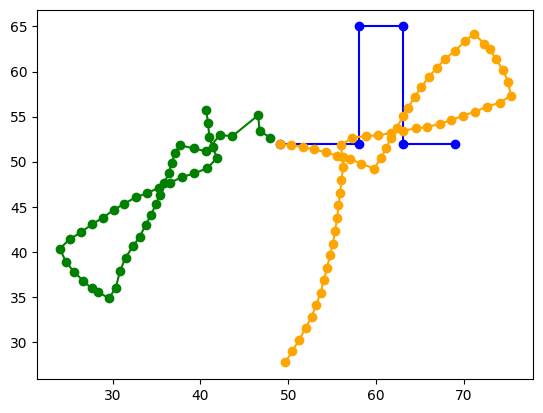

# of particle: 3000
move_particles 실행 시간: 0.00128초
calculate_weights 실행 시간: 0.09311초
resample_particles 실행 시간: 0.00083초
estimate_position 실행 시간: 0.00060초
run_filter 실행 시간: 0.10058초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

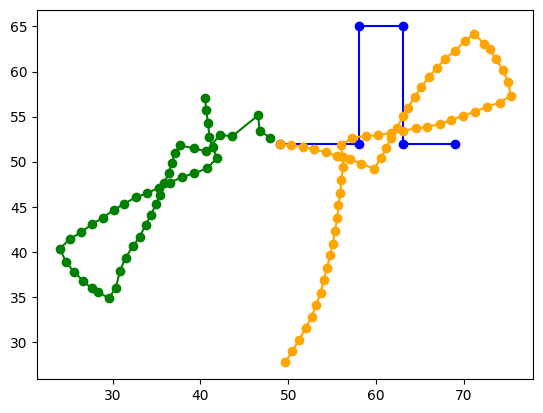

# of particle: 3000
move_particles 실행 시간: 0.00165초
calculate_weights 실행 시간: 0.14831초
resample_particles 실행 시간: 0.00141초
estimate_position 실행 시간: 0.00255초
run_filter 실행 시간: 0.16659초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

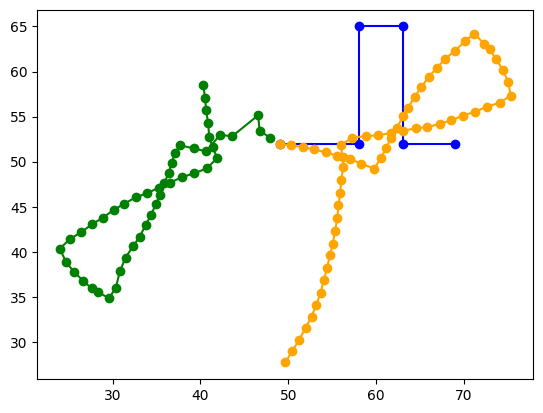

# of particle: 3000
move_particles 실행 시간: 0.00324초
calculate_weights 실행 시간: 0.41724초
resample_particles 실행 시간: 0.00093초
estimate_position 실행 시간: 0.00059초
run_filter 실행 시간: 0.42621초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

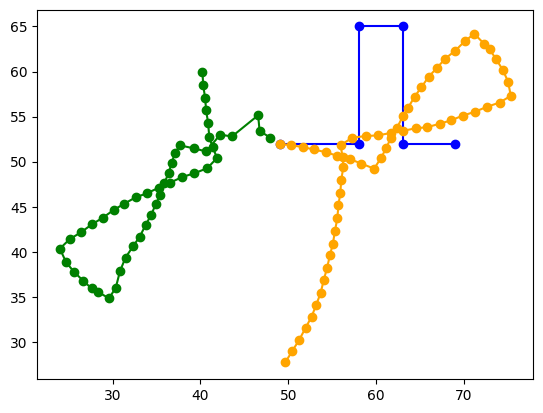

# of particle: 3000
move_particles 실행 시간: 0.00279초
calculate_weights 실행 시간: 0.12610초
resample_particles 실행 시간: 0.00154초
estimate_position 실행 시간: 0.00163초
run_filter 실행 시간: 0.13767초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

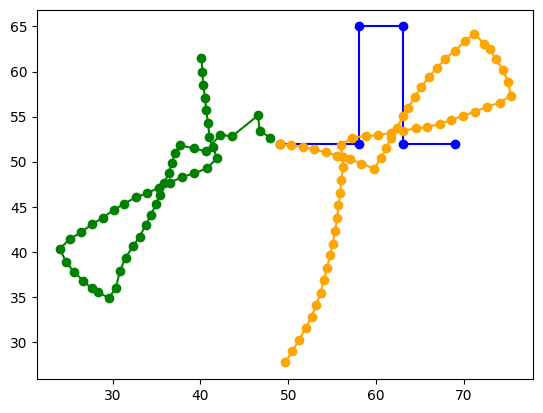

# of particle: 3000
move_particles 실행 시간: 0.00145초
calculate_weights 실행 시간: 0.15963초
resample_particles 실행 시간: 0.00194초
estimate_position 실행 시간: 0.00070초
run_filter 실행 시간: 0.16835초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

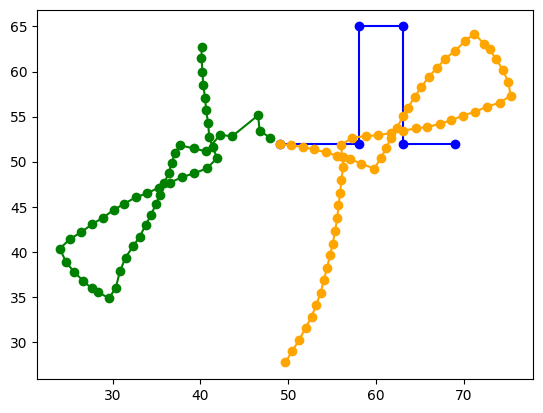

# of particle: 3000
move_particles 실행 시간: 0.00222초
calculate_weights 실행 시간: 0.09152초
resample_particles 실행 시간: 0.00079초
estimate_position 실행 시간: 0.00058초
run_filter 실행 시간: 0.09918초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

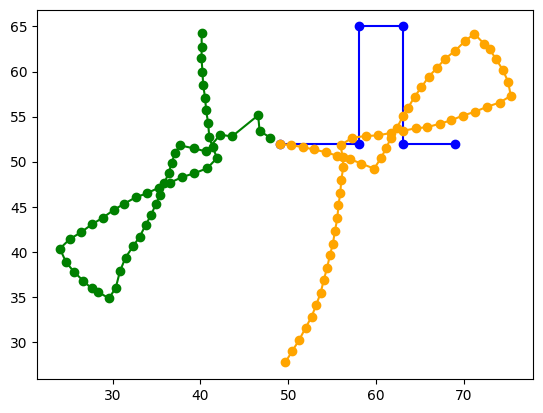

# of particle: 3000
move_particles 실행 시간: 0.00149초
calculate_weights 실행 시간: 0.20334초
resample_particles 실행 시간: 0.00183초
estimate_position 실행 시간: 0.00070초
run_filter 실행 시간: 0.21261초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

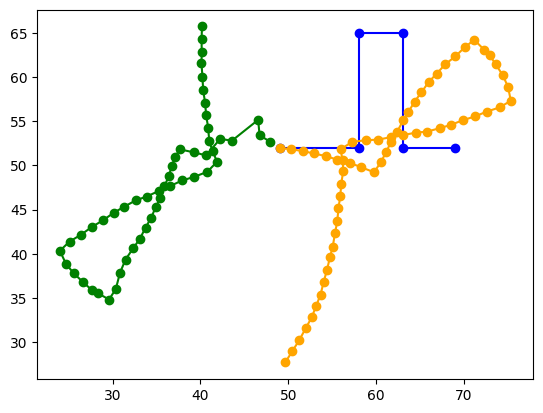

# of particle: 3000
move_particles 실행 시간: 0.00158초
calculate_weights 실행 시간: 0.38895초
resample_particles 실행 시간: 0.00092초
estimate_position 실행 시간: 0.00061초
run_filter 실행 시간: 0.39993초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

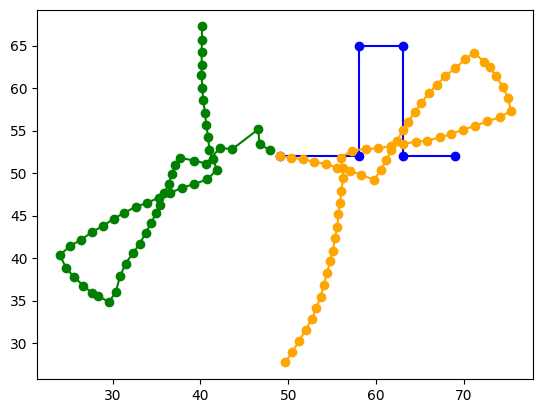

# of particle: 3000
move_particles 실행 시간: 0.00165초
calculate_weights 실행 시간: 0.09781초
resample_particles 실행 시간: 0.00086초
estimate_position 실행 시간: 0.00061초
run_filter 실행 시간: 0.10493초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

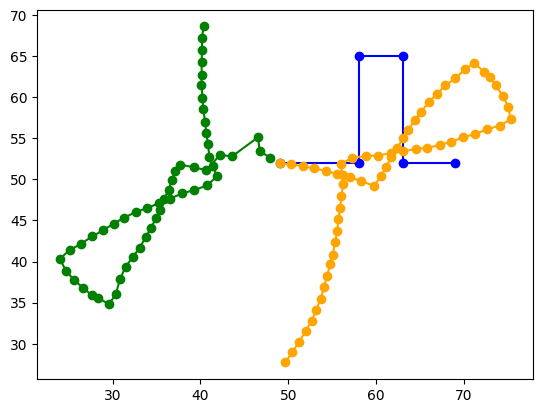

# of particle: 3000
move_particles 실행 시간: 0.00153초
calculate_weights 실행 시간: 0.15303초
resample_particles 실행 시간: 0.00169초
estimate_position 실행 시간: 0.00149초
run_filter 실행 시간: 0.16521초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

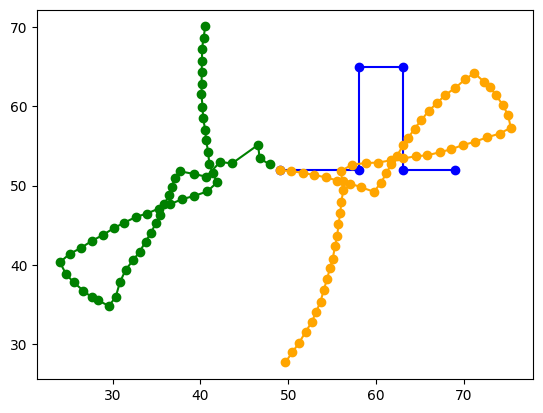

# of particle: 3000
move_particles 실행 시간: 0.00169초
calculate_weights 실행 시간: 0.09239초
resample_particles 실행 시간: 0.00097초
estimate_position 실행 시간: 0.00064초
run_filter 실행 시간: 0.10487초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

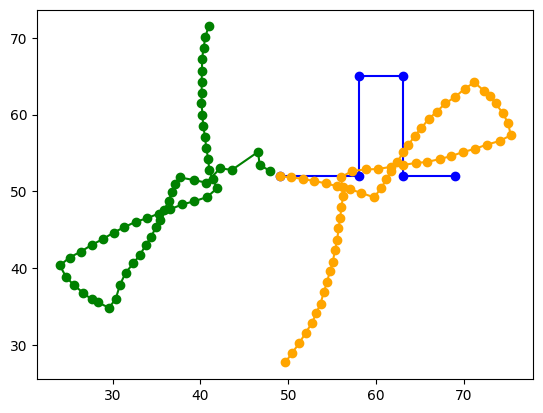

# of particle: 3000
move_particles 실행 시간: 0.00187초
calculate_weights 실행 시간: 0.15963초
resample_particles 실행 시간: 0.00170초
estimate_position 실행 시간: 0.00073초
run_filter 실행 시간: 0.16809초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

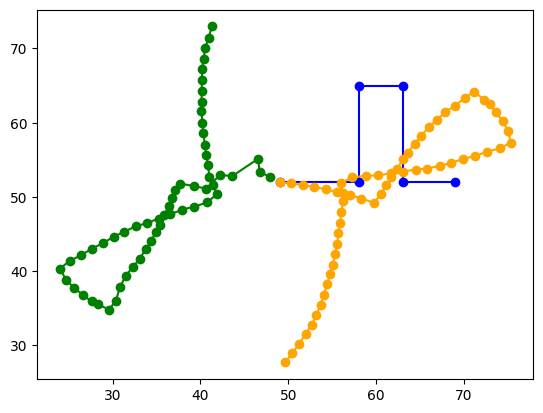

# of particle: 3000
move_particles 실행 시간: 0.00269초
calculate_weights 실행 시간: 0.38904초
resample_particles 실행 시간: 0.00094초
estimate_position 실행 시간: 0.00059초
run_filter 실행 시간: 0.39788초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

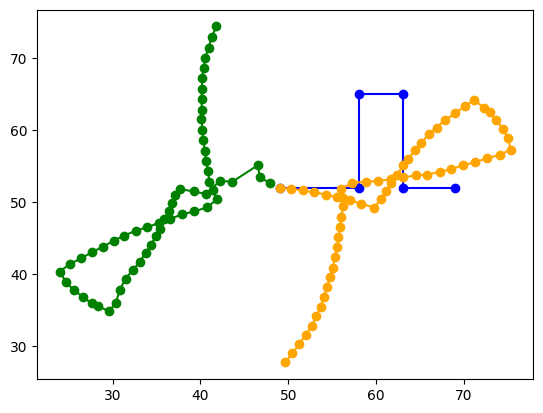

# of particle: 3000
move_particles 실행 시간: 0.00231초
calculate_weights 실행 시간: 0.09422초
resample_particles 실행 시간: 0.00093초
estimate_position 실행 시간: 0.00064초
run_filter 실행 시간: 0.10421초
[(47.925541585773715, 52.666000858486925), (46.73037962895189, 53.42592199697172), (46.56665516016987, 55.1468879739936), (43.58741914970751, 52.79229242735992), (42.24133380916532, 52.99758770762735), (40.65686432923816, 51.1287729082742), (39.263964000340806, 51.47168872173704), (37.65557026575735, 51.809641174005144), (37.13102532798965, 50.99974886495853), (36.71583872601319, 49.887672470206205), (36.40235102632839, 48.77123345572073), (35.883284486046236, 47.62610330594858), (35.39879011591248, 46.27661693705477), (34.94813946102166, 45.350151909420156), (34.383985276153396, 44.082101984612535), (33.75388313767328, 42.955436907474635), (33.0967559451944, 41.69001612765225), (32.32882267359889, 40.60404236884526), (31.472831077239213, 39.35472838869798), (30.840446949772623, 37.84643354627565), (30.36524

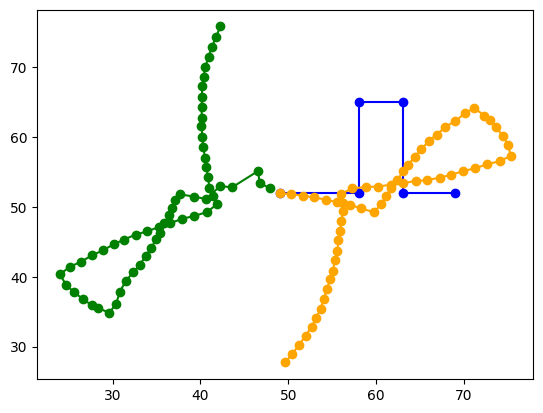

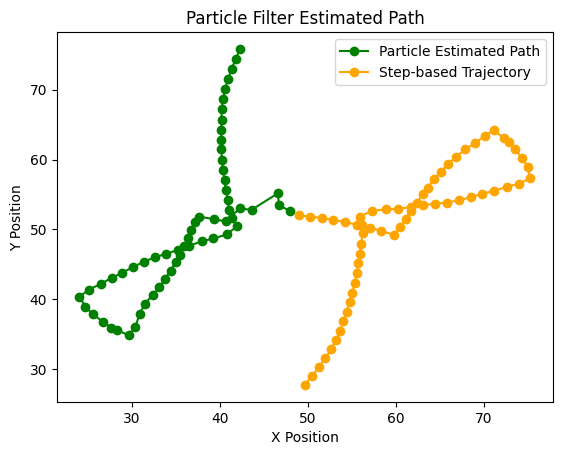

In [548]:
from step_length import *
from step_orientation import *

acc_df = pd.read_csv("../data/Path4_freeOri_A31_12_05/Accelerometer.csv")
gyro_df = pd.read_csv("../data/Path4_freeOri_A31_12_05/GyroscopeUncalibrated.csv")
mag_df = pd.read_csv("../data/Path4_freeOri_A31_12_05/MagnetometerUncalibrated.csv")
mag_df['mag'] = mag_df.apply(lambda x: math.sqrt(x['x']*x['x'] + x['y']*x['y'] + x['z']*x['z']), axis=1 )
del mag_df['x']
del mag_df['y']
del mag_df['z']

path_1 = pd.DataFrame([(92, 47), (102, 47), (102, 40), (92,40), (92,47)], columns=['x', 'y'])
path_2 = pd.DataFrame([(114, 25), (118, 25), (118, 13), (114,13), (114, 25)], columns=['x', 'y'])
path_3 = pd.DataFrame([(33, 28), (38, 28), (44, 22)], columns=['x', 'y'])
path_4 = pd.DataFrame([(49, 52), (58, 52), (58, 65), (63, 65), (63, 52), (69, 52)], columns=['x', 'y'])

step_lengths = compute_step_timestamp(
    acceleration_threshold=0.01,
    weinberg_gain=0.65,
    acce=acc_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
    frequency=100.0
)
step_orientation_radians: list[float] = []

# Plot Ground Truth Path
# plt.plot(path_1['x'], path_1['y'], marker='o', color='blue', label='Ground Truth Path')
# plt.plot(path_2['x'], path_2['y'], marker='o', color='blue', label='Ground Truth Path')
# plt.plot(path_3['x'], path_3['y'], marker='o', color='blue', label='Ground Truth Path')
# plt.plot(path_4['x'], path_4['y'], marker='o', color='blue', label='Ground Truth Path')

# Tranjectory
x, y = 49, 52  # 초기 위치
trajectory_x = [x]
trajectory_y = [y]
current_angle = 0  # 초기 방향 (radians)

for step in step_lengths:
    step_length = step['step_length']
    start = step['start']
    end = step['end']

    # Turning estimation
    estimated_radian = estimate_turning_angle(
        gyro_data=gyro_df.iloc[start:end, :],
        frequency=100.0
    )
    step_orientation_radians.append(estimated_radian)

    # 방향 업데이트
    current_angle += estimated_radian  
    
    step_length /= 0.6
    # 새로운 위치 계산
    dx = step_length * math.cos(current_angle)
    dy = step_length * math.sin(current_angle)
    x += dx
    y += dy
    trajectory_x.append(x)
    trajectory_y.append(y)

print(f"assert that len(step_length): {len(step_lengths)} = len(step_orientation_radians): {len(step_orientation_radians)}")

estimated_positions = []

for idx, (step_length, step_orientation_radian) in enumerate(zip(step_lengths, step_orientation_radians)):
    length = step_length['step_length']
    start = step_length['start']
    end = step_length['end']
    
    use_weighted_average = True
    if 0 <= idx < 5:
        use_weighted_average = False

    result = pf.run_filter(mag_df.iloc[start:end], length, step_orientation_radian, use_weighted_average)
    estimated_positions += result
    
    print(estimated_positions)
    # NumPy 배열로 변환
    positions_array = np.array(estimated_positions)
    
    # 첫 번째 점
    if idx == 0:
        plt.plot(positions_array[0, 0], positions_array[0, 1], marker='o', color='green', label="Particle Estimated Path")
    else:
        # 이전까지의 경로
        plt.plot(positions_array[:idx+1, 0], positions_array[:idx+1, 1], marker='o', color='green', label="Particle Estimated Path")

    plt.plot(path_4['x'], path_4['y'], marker='o', color='blue', label='Ground Truth Path')
    plt.plot(trajectory_x, trajectory_y, marker='o', color='orange', label="Step-based Trajectory")
    plt.show()

#Plot results
estimated_positions = np.array(estimated_positions)
estimated_positions = np.squeeze(estimated_positions)  # (n, 2)로 변환

plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], marker='o', color='green', label="Particle Estimated Path")
plt.plot(trajectory_x, trajectory_y, marker='o', color='orange', label="Step-based Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Particle Filter Estimated Path")
plt.show()
